# CT Data Normalization for 3D Pix2Pix Training

This notebook focuses on normalizing CT medical imaging data to prepare it for 3D pix2pix training. We'll load the CT data, resample it to match the MR latent dimensions, apply proper intensity normalization, and save the result as `CT_normalised_latent.mha`.

## Overview
- **Input**: `ct.mha` (110, 389, 494) - Original CT volume
- **Target**: MR latent dimensions (32, 128, 128) for training compatibility  
- **Output**: `CT_normalised_latent.mha` - Normalized and resampled CT
- **Goal**: Prepare CT data for paired training with MR latent representation

## 1. Import Required Libraries

In [1]:
# Essential libraries for medical imaging and data processing
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy import ndimage
import os
import warnings
warnings.filterwarnings('ignore')


## 2. Load and Inspect CT Data

Load the original CT file and examine its properties including dimensions, spacing, intensity range, and basic statistics.

In [8]:
# Load CT data using SimpleITK
ct_file_path = "/Users/samwallace/Documents/sCT/Comparison Pix2Pix/3D/datasets/overfit/ct.mha"

print("🏥 LOADING CT DATA")
print("=" * 50)

# Check if file exists
if os.path.exists(ct_file_path):
    print(f"📁 Loading: {ct_file_path}")
    
    # Load the CT image
    ct_image = sitk.ReadImage(ct_file_path)
    ct_array = sitk.GetArrayFromImage(ct_image)
    
    print("✅ CT data loaded successfully!")
    
    # Display basic image properties
    print(f"\n📊 IMAGE PROPERTIES:")
    print(f"   Shape: {ct_array.shape}")
    print(f"   Data type: {ct_array.dtype}")
    print(f"   Spacing: {ct_image.GetSpacing()} mm")
    print(f"   Origin: {ct_image.GetOrigin()} mm")
    print(f"   Size: {ct_image.GetSize()}")
    
    # Display statistical information
    print(f"\n📈 INTENSITY STATISTICS:")
    print(f"   Min value: {np.min(ct_array):.2f} HU")
    print(f"   Max value: {np.max(ct_array):.2f} HU") 
    print(f"   Mean: {np.mean(ct_array):.2f} HU")
    print(f"   Std dev: {np.std(ct_array):.2f} HU")
    print(f"   Median: {np.median(ct_array):.2f} HU")
    
    # Calculate memory usage
    memory_mb = ct_array.nbytes / (1024 * 1024)
    print(f"\n💾 MEMORY USAGE: {memory_mb:.1f} MB")
    
else:
    print(f"❌ File not found: {ct_file_path}")
    print(f"📂 Current directory: {os.getcwd()}")
    print(f"📋 Available files: {os.listdir('.')}")

🏥 LOADING CT DATA
📁 Loading: /Users/samwallace/Documents/sCT/Comparison Pix2Pix/3D/datasets/overfit/ct.mha
✅ CT data loaded successfully!

📊 IMAGE PROPERTIES:
   Shape: (110, 389, 494)
   Data type: int16
   Spacing: (1.0, 1.0, 1.0) mm
   Origin: (-227.0, -128.0, 0.0) mm
   Size: (494, 389, 110)

📈 INTENSITY STATISTICS:
   Min value: -1024.00 HU
   Max value: 3061.00 HU
   Mean: -751.27 HU
   Std dev: 428.41 HU
   Median: -1000.00 HU

💾 MEMORY USAGE: 40.3 MB



🖼️  VISUALIZING CT SLICES


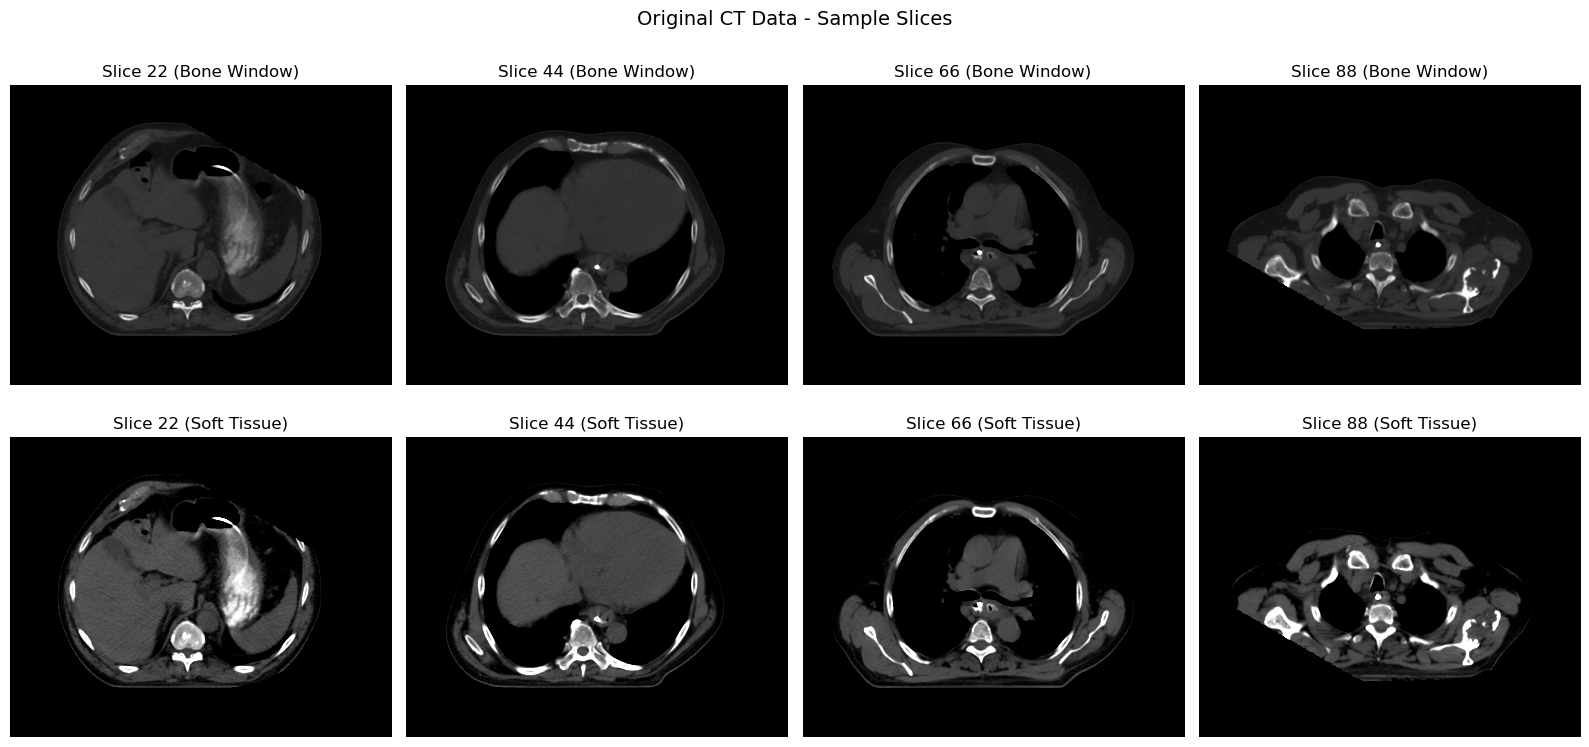

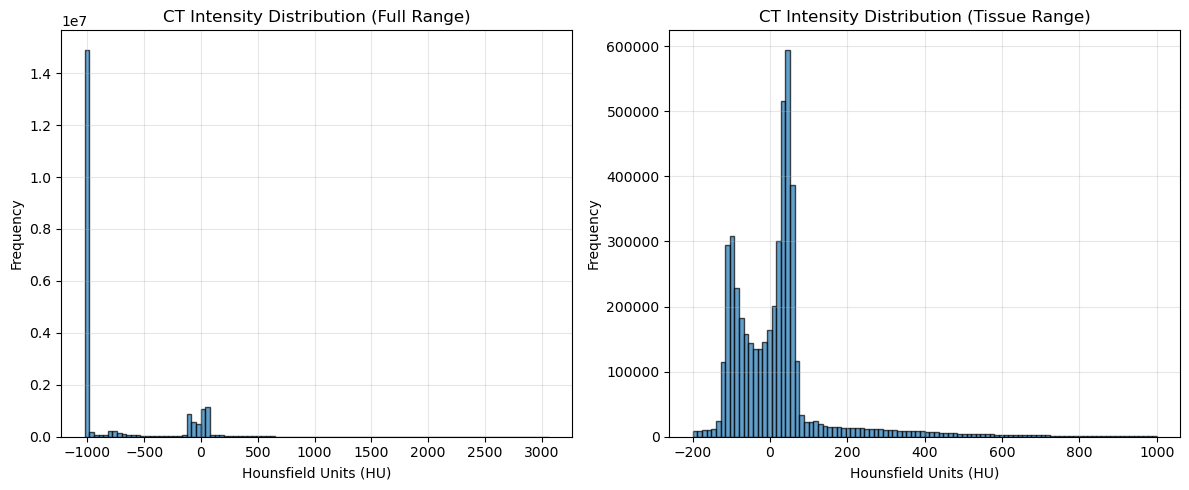

✅ Visualization complete - CT has 110 slices


In [9]:
# Visualize CT slices to understand the data
print("\n🖼️  VISUALIZING CT SLICES")
print("=" * 50)

# Create visualization of sample slices
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Original CT Data - Sample Slices', fontsize=14)

# Select representative slices (evenly distributed)
slice_indices = [
    int(ct_array.shape[0] * 0.2),   # 20% through volume
    int(ct_array.shape[0] * 0.4),   # 40% through volume  
    int(ct_array.shape[0] * 0.6),   # 60% through volume
    int(ct_array.shape[0] * 0.8)    # 80% through volume
]

# Display slices with different window settings
for i, slice_idx in enumerate(slice_indices):
    # Top row: Bone window (good for seeing anatomy)
    axes[0, i].imshow(ct_array[slice_idx], cmap='gray', vmin=-200, vmax=1000)
    axes[0, i].set_title(f'Slice {slice_idx} (Bone Window)')
    axes[0, i].axis('off')
    
    # Bottom row: Soft tissue window  
    axes[1, i].imshow(ct_array[slice_idx], cmap='gray', vmin=-100, vmax=400)
    axes[1, i].set_title(f'Slice {slice_idx} (Soft Tissue)')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Display intensity histogram
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(ct_array.flatten(), bins=100, alpha=0.7, edgecolor='black')
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Frequency')
plt.title('CT Intensity Distribution (Full Range)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Focus on main tissue range (-200 to 1000 HU)
plt.hist(ct_array.flatten(), bins=100, range=(-200, 1000), alpha=0.7, edgecolor='black')
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Frequency')
plt.title('CT Intensity Distribution (Tissue Range)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Visualization complete - CT has {ct_array.shape[0]} slices")

## 3. Define Target Dimensions

Set target dimensions to match MR latent representation for 3D pix2pix training compatibility.

In [10]:
# Define target dimensions to match MR latent representation
print("🎯 TARGET DIMENSIONS FOR 3D PIX2PIX")
print("=" * 50)

# MR latent dimensions (from analysis in inspection.ipynb)
# MR latent shape: (32, 128, 128, 4) where 4 is channels
target_depth = 32
target_height = 128  
target_width = 128

print(f"📏 CURRENT CT DIMENSIONS:")
print(f"   Depth (slices): {ct_array.shape[0]}")
print(f"   Height: {ct_array.shape[1]}")
print(f"   Width: {ct_array.shape[2]}")
print(f"   Total size: {ct_array.shape}")

print(f"\n🎯 TARGET DIMENSIONS:")
print(f"   Depth (slices): {target_depth}")
print(f"   Height: {target_height}")
print(f"   Width: {target_width}")
print(f"   Target size: ({target_depth}, {target_height}, {target_width})")

# Calculate zoom factors for resampling
zoom_depth = target_depth / ct_array.shape[0]
zoom_height = target_height / ct_array.shape[1]
zoom_width = target_width / ct_array.shape[2]

print(f"\n🔍 RESAMPLING REQUIREMENTS:")
print(f"   Depth zoom factor: {zoom_depth:.4f} ({ct_array.shape[0]} → {target_depth})")
print(f"   Height zoom factor: {zoom_height:.4f} ({ct_array.shape[1]} → {target_height})")
print(f"   Width zoom factor: {zoom_width:.4f} ({ct_array.shape[2]} → {target_width})")

zoom_factors = [zoom_depth, zoom_height, zoom_width]
print(f"   Combined zoom: {zoom_factors}")

# Calculate memory impact
original_memory = ct_array.nbytes / (1024 * 1024)
target_memory = target_depth * target_height * target_width * 4 / (1024 * 1024)  # float32
memory_reduction = original_memory / target_memory

print(f"\n💾 MEMORY IMPACT:")
print(f"   Original: {original_memory:.1f} MB")
print(f"   Target: {target_memory:.1f} MB")
print(f"   Reduction: {memory_reduction:.1f}x smaller")

print(f"\n✅ Resampling will reduce data size by {memory_reduction:.1f}x for efficient training")

🎯 TARGET DIMENSIONS FOR 3D PIX2PIX
📏 CURRENT CT DIMENSIONS:
   Depth (slices): 110
   Height: 389
   Width: 494
   Total size: (110, 389, 494)

🎯 TARGET DIMENSIONS:
   Depth (slices): 32
   Height: 128
   Width: 128
   Target size: (32, 128, 128)

🔍 RESAMPLING REQUIREMENTS:
   Depth zoom factor: 0.2909 (110 → 32)
   Height zoom factor: 0.3290 (389 → 128)
   Width zoom factor: 0.2591 (494 → 128)
   Combined zoom: [0.2909090909090909, 0.32904884318766064, 0.2591093117408907]

💾 MEMORY IMPACT:
   Original: 40.3 MB
   Target: 2.0 MB
   Reduction: 20.2x smaller

✅ Resampling will reduce data size by 20.2x for efficient training


## 4. Spatial Resampling

Resample the CT volume to match target dimensions using high-quality interpolation methods.

In [11]:
# Perform spatial resampling using scipy ndimage
print("🔄 SPATIAL RESAMPLING")
print("=" * 50)

print("📐 Starting resampling process...")
print(f"   Input shape: {ct_array.shape}")
print(f"   Target shape: ({target_depth}, {target_height}, {target_width})")
print(f"   Zoom factors: {zoom_factors}")

# Perform resampling using linear interpolation (order=1)
# order=1: Linear interpolation (good balance of quality and speed)
# order=3: Cubic interpolation (higher quality but slower)
print("\n⚙️  Applying zoom transformation...")
ct_resampled = ndimage.zoom(ct_array, zoom_factors, order=1)

print("✅ Resampling complete!")
print(f"   Original shape: {ct_array.shape}")
print(f"   Resampled shape: {ct_resampled.shape}")

# Verify dimensions match target exactly
if ct_resampled.shape == (target_depth, target_height, target_width):
    print("✅ Dimensions match target perfectly!")
else:
    print(f"⚠️  Dimension mismatch!")
    print(f"   Expected: ({target_depth}, {target_height}, {target_width})")
    print(f"   Got: {ct_resampled.shape}")

# Check data integrity after resampling
print(f"\n📊 RESAMPLED DATA STATISTICS:")
print(f"   Min value: {np.min(ct_resampled):.2f} HU")
print(f"   Max value: {np.max(ct_resampled):.2f} HU")
print(f"   Mean: {np.mean(ct_resampled):.2f} HU")
print(f"   Std dev: {np.std(ct_resampled):.2f} HU")

# Calculate memory usage
resampled_memory = ct_resampled.nbytes / (1024 * 1024)
print(f"\n💾 Memory usage: {resampled_memory:.1f} MB")

print(f"\n🎯 Ready for intensity normalization!")

🔄 SPATIAL RESAMPLING
📐 Starting resampling process...
   Input shape: (110, 389, 494)
   Target shape: (32, 128, 128)
   Zoom factors: [0.2909090909090909, 0.32904884318766064, 0.2591093117408907]

⚙️  Applying zoom transformation...
✅ Resampling complete!
   Original shape: (110, 389, 494)
   Resampled shape: (32, 128, 128)
✅ Dimensions match target perfectly!

📊 RESAMPLED DATA STATISTICS:
   Min value: -1024.00 HU
   Max value: 2792.00 HU
   Mean: -759.59 HU
   Std dev: 421.03 HU

💾 Memory usage: 1.0 MB

🎯 Ready for intensity normalization!



🖼️  COMPARING ORIGINAL vs RESAMPLED


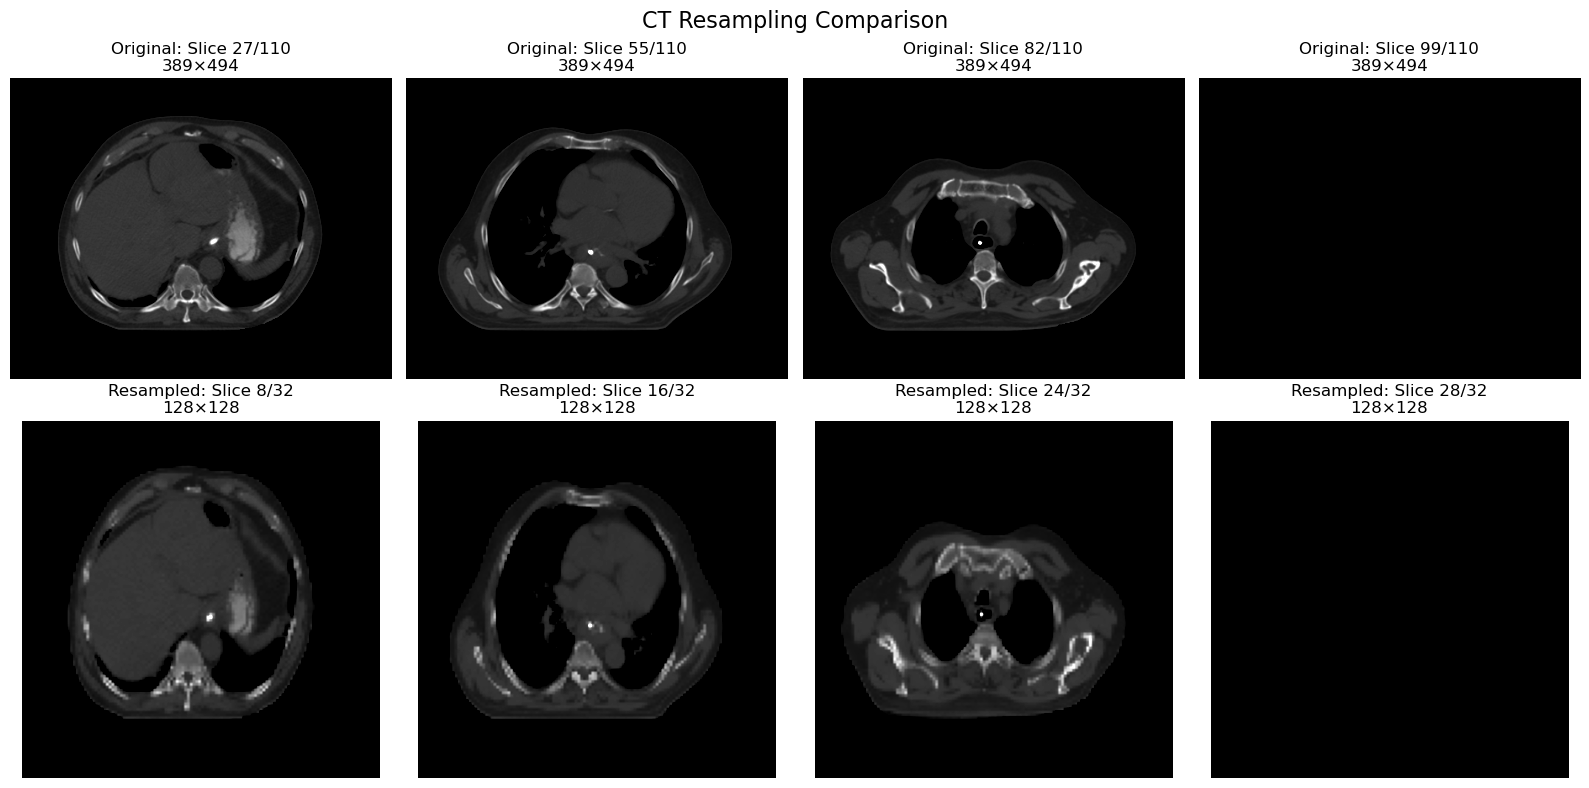

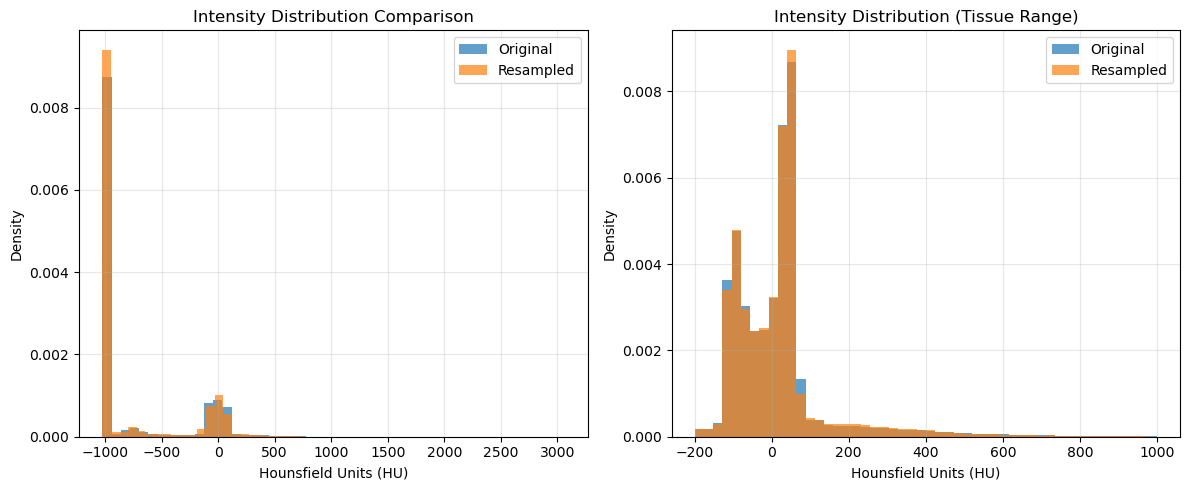

✅ Resampling preserves anatomical structure and intensity distribution


In [12]:
# Visualize comparison between original and resampled CT
print("\n🖼️  COMPARING ORIGINAL vs RESAMPLED")
print("=" * 50)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('CT Resampling Comparison', fontsize=16)

# Select corresponding slices for comparison
original_slices = [
    int(ct_array.shape[0] * 0.25),
    int(ct_array.shape[0] * 0.5),
    int(ct_array.shape[0] * 0.75),
    int(ct_array.shape[0] * 0.9)
]

resampled_slices = [
    int(ct_resampled.shape[0] * 0.25),
    int(ct_resampled.shape[0] * 0.5), 
    int(ct_resampled.shape[0] * 0.75),
    int(ct_resampled.shape[0] * 0.9)
]

# Display original slices (top row)
for i, slice_idx in enumerate(original_slices):
    axes[0, i].imshow(ct_array[slice_idx], cmap='gray', vmin=-200, vmax=1000)
    axes[0, i].set_title(f'Original: Slice {slice_idx}/{ct_array.shape[0]}\n{ct_array.shape[1]}×{ct_array.shape[2]}')
    axes[0, i].axis('off')

# Display resampled slices (bottom row)  
for i, slice_idx in enumerate(resampled_slices):
    axes[1, i].imshow(ct_resampled[slice_idx], cmap='gray', vmin=-200, vmax=1000)
    axes[1, i].set_title(f'Resampled: Slice {slice_idx}/{ct_resampled.shape[0]}\n{ct_resampled.shape[1]}×{ct_resampled.shape[2]}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Compare intensity distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(ct_array.flatten(), bins=50, alpha=0.7, label='Original', density=True)
plt.hist(ct_resampled.flatten(), bins=50, alpha=0.7, label='Resampled', density=True)
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Density')
plt.title('Intensity Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Focus on tissue range
plt.hist(ct_array.flatten(), bins=50, range=(-200, 1000), alpha=0.7, label='Original', density=True)
plt.hist(ct_resampled.flatten(), bins=50, range=(-200, 1000), alpha=0.7, label='Resampled', density=True)
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Density')
plt.title('Intensity Distribution (Tissue Range)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Resampling preserves anatomical structure and intensity distribution")

## 5. Intensity Normalization

Apply intensity normalization to scale CT values to a suitable range for neural network training.

In [18]:
hu_min = -1024  # Air
hu_max = 1200  

In [19]:
# Apply intensity normalization for neural network training
print("🎨 INTENSITY NORMALIZATION")
print("=" * 50)

# Step 1: Define reasonable HU range for medical CT
# Standard tissue range: -1024 (air) to +3071 (dense bone)
# For training, we'll use a more focused range


print(f"📏 NORMALIZATION PARAMETERS:")
print(f"   HU range: [{hu_min}, {hu_max}]")
print(f"   Target range: [-1, 1] (standard for neural networks)")

# Step 2: Clip extreme values
print(f"\n🔧 CLIPPING EXTREME VALUES...")
print(f"   Before clipping: [{np.min(ct_resampled):.1f}, {np.max(ct_resampled):.1f}] HU")

ct_clipped = np.clip(ct_resampled, hu_min, hu_max)

print(f"   After clipping: [{np.min(ct_clipped):.1f}, {np.max(ct_clipped):.1f}] HU")

# Step 3: Normalize to [-1, 1] range
print(f"\n📐 SCALING TO [-1, 1] RANGE...")
ct_normalized = (ct_clipped - hu_min) / (hu_max - hu_min)  # Scale to [0, 1]
ct_normalized = ct_normalized * 2 - 1  # Scale to [-1, 1]

print(f"   Normalized range: [{np.min(ct_normalized):.3f}, {np.max(ct_normalized):.3f}]")

# Verify normalization
print(f"\n✅ NORMALIZATION RESULTS:")
print(f"   Original CT: {ct_resampled.shape}, range [{np.min(ct_resampled):.1f}, {np.max(ct_resampled):.1f}] HU")
print(f"   Normalized CT: {ct_normalized.shape}, range [{np.min(ct_normalized):.3f}, {np.max(ct_normalized):.3f}]")
print(f"   Data type: {ct_normalized.dtype}")
print(f"   Mean: {np.mean(ct_normalized):.3f}")
print(f"   Std: {np.std(ct_normalized):.3f}")

# Alternative normalization methods (commented for reference)
print(f"\n💡 ALTERNATIVE NORMALIZATION METHODS:")
print("   # Z-score normalization:")
print("   # ct_zscore = (ct_resampled - np.mean(ct_resampled)) / np.std(ct_resampled)")
print("   #")
print("   # Min-max to [0, 1]:")
print("   # ct_minmax = (ct_resampled - np.min(ct_resampled)) / (np.max(ct_resampled) - np.min(ct_resampled))")
print("   #")
print("   # Robust scaling (using percentiles):")
print("   # p1, p99 = np.percentile(ct_resampled, [1, 99])")
print("   # ct_robust = np.clip((ct_resampled - p1) / (p99 - p1), 0, 1)")


print(f"\n🎯 Using clipped [-1024, 1024] HU → [-1, 1] normalization (recommended for medical CT)")

🎨 INTENSITY NORMALIZATION
📏 NORMALIZATION PARAMETERS:
   HU range: [-1024, 1200]
   Target range: [-1, 1] (standard for neural networks)

🔧 CLIPPING EXTREME VALUES...
   Before clipping: [-1024.0, 2792.0] HU
   After clipping: [-1024.0, 1200.0] HU

📐 SCALING TO [-1, 1] RANGE...
   Normalized range: [-1.000, 1.000]

✅ NORMALIZATION RESULTS:
   Original CT: (32, 128, 128), range [-1024.0, 2792.0] HU
   Normalized CT: (32, 128, 128), range [-1.000, 1.000]
   Data type: float64
   Mean: -0.762
   Std: 0.378

💡 ALTERNATIVE NORMALIZATION METHODS:
   # Z-score normalization:
   # ct_zscore = (ct_resampled - np.mean(ct_resampled)) / np.std(ct_resampled)
   #
   # Min-max to [0, 1]:
   # ct_minmax = (ct_resampled - np.min(ct_resampled)) / (np.max(ct_resampled) - np.min(ct_resampled))
   #
   # Robust scaling (using percentiles):
   # p1, p99 = np.percentile(ct_resampled, [1, 99])
   # ct_robust = np.clip((ct_resampled - p1) / (p99 - p1), 0, 1)

🎯 Using clipped [-1024, 1024] HU → [-1, 1] normali


🖼️  NORMALIZATION VISUALIZATION


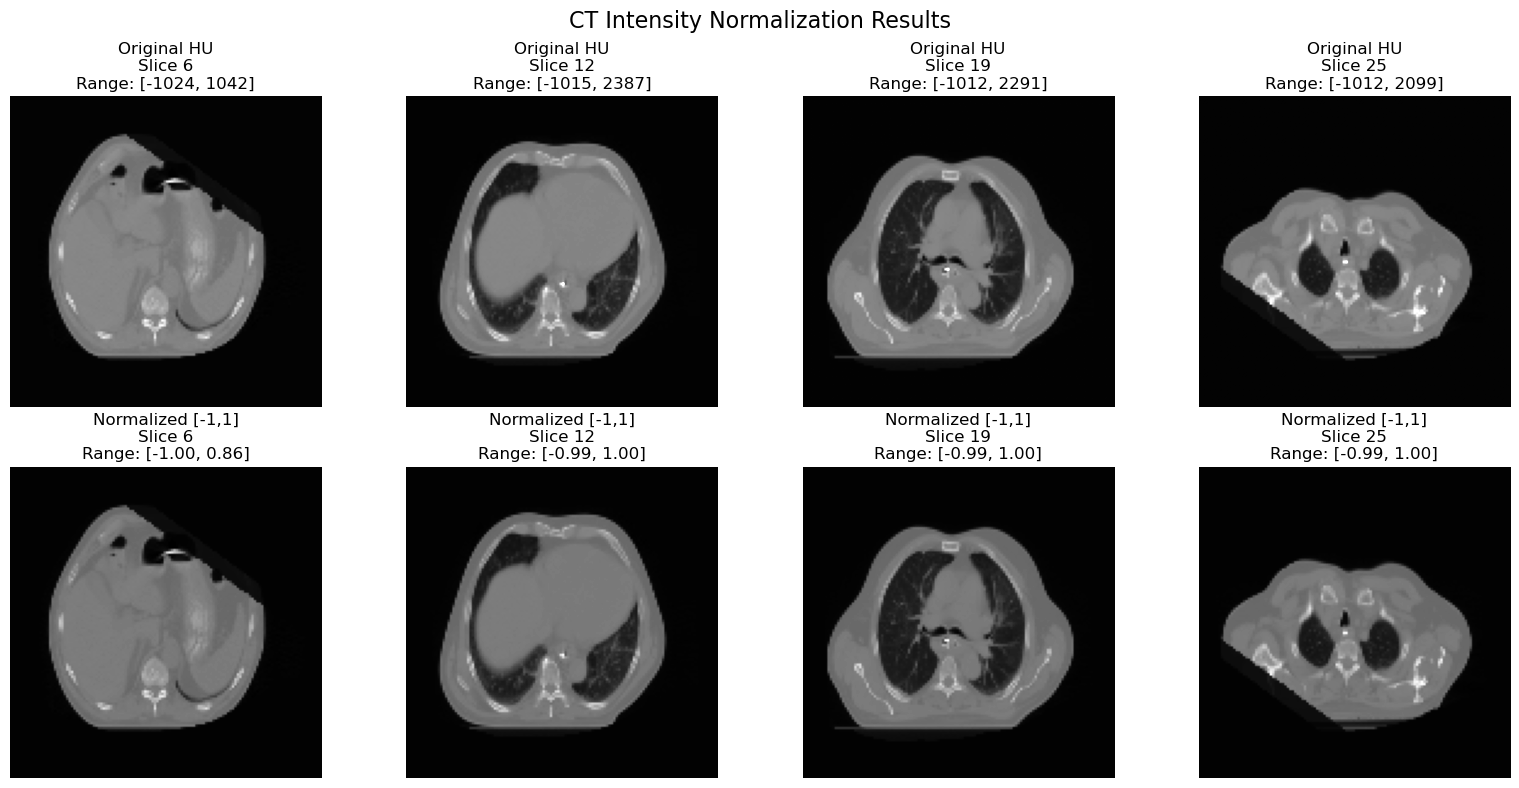

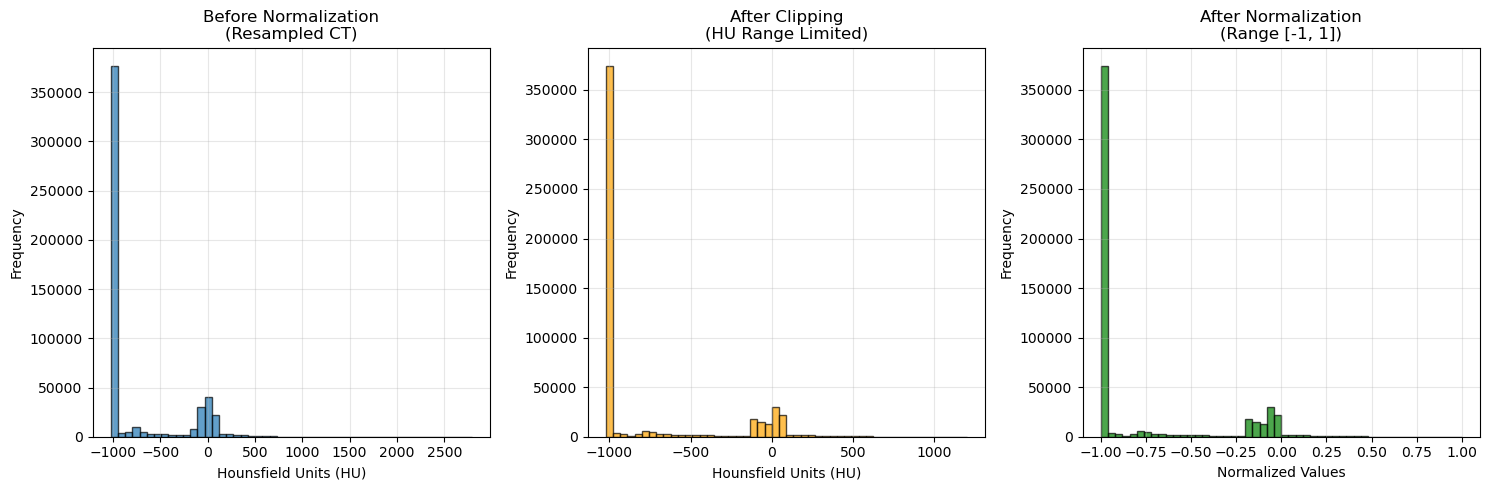

📊 STATISTICAL COMPARISON:
Original   - Mean: -759.59, Std:  421.03, Range: [-1024.0,  2792.0]
Clipped    - Mean: -759.63, Std:  420.82, Range: [-1024.0,  1200.0]
Normalized - Mean:  -0.762, Std:   0.378, Range: [ -1.000,   1.000]

✅ Normalization complete - CT data ready for neural network training!


In [20]:
# Visualize normalization effects
print("\n🖼️  NORMALIZATION VISUALIZATION")
print("=" * 50)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('CT Intensity Normalization Results', fontsize=16)

# Select middle slices for comparison
middle_slice_idx = ct_normalized.shape[0] // 2

# Top row: Before normalization (resampled HU values)
for i in range(4):
    slice_idx = int(ct_resampled.shape[0] * (0.2 + i * 0.2))
    axes[0, i].imshow(ct_resampled[slice_idx], cmap='gray', vmin=-1024, vmax=1024)
    axes[0, i].set_title(f'Original HU\nSlice {slice_idx}\nRange: [{np.min(ct_resampled[slice_idx]):.0f}, {np.max(ct_resampled[slice_idx]):.0f}]')
    axes[0, i].axis('off')

# Bottom row: After normalization ([-1, 1] values)
for i in range(4):
    slice_idx = int(ct_normalized.shape[0] * (0.2 + i * 0.2))
    axes[1, i].imshow(ct_normalized[slice_idx], cmap='gray', vmin=-1, vmax=1)
    axes[1, i].set_title(f'Normalized [-1,1]\nSlice {slice_idx}\nRange: [{np.min(ct_normalized[slice_idx]):.2f}, {np.max(ct_normalized[slice_idx]):.2f}]')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Compare intensity distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(ct_resampled.flatten(), bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Frequency')
plt.title('Before Normalization\n(Resampled CT)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2) 
plt.hist(ct_clipped.flatten(), bins=50, alpha=0.7, edgecolor='black', color='orange')
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Frequency')
plt.title('After Clipping\n(HU Range Limited)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(ct_normalized.flatten(), bins=50, alpha=0.7, edgecolor='black', color='green')
plt.xlabel('Normalized Values')
plt.ylabel('Frequency')
plt.title('After Normalization\n(Range [-1, 1])')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison
print("📊 STATISTICAL COMPARISON:")
print(f"Original   - Mean: {np.mean(ct_resampled):7.2f}, Std: {np.std(ct_resampled):7.2f}, Range: [{np.min(ct_resampled):7.1f}, {np.max(ct_resampled):7.1f}]")
print(f"Clipped    - Mean: {np.mean(ct_clipped):7.2f}, Std: {np.std(ct_clipped):7.2f}, Range: [{np.min(ct_clipped):7.1f}, {np.max(ct_clipped):7.1f}]")
print(f"Normalized - Mean: {np.mean(ct_normalized):7.3f}, Std: {np.std(ct_normalized):7.3f}, Range: [{np.min(ct_normalized):7.3f}, {np.max(ct_normalized):7.3f}]")

print("\n✅ Normalization complete - CT data ready for neural network training!")

## 6. Save Normalized CT Data

Save the processed CT data as `CT_normalised_latent.mha` for use in 3D pix2pix training.

In [22]:
# Save the normalized CT data as CT_normalised_latent.mha
print("💾 SAVING NORMALIZED CT DATA")
print("=" * 50)

# Define output filename
output_filename = "../datasets/overfit/CT_normalised_latent.mha"


print(f"📁 Output file: {output_filename}")
print(f"📏 Data shape: {ct_normalized.shape}")
print(f"📊 Data range: [{np.min(ct_normalized):.3f}, {np.max(ct_normalized):.3f}]")
print(f"🔢 Data type: {ct_normalized.dtype}")

# Create SimpleITK image from normalized array
ct_normalized_sitk = sitk.GetImageFromArray(ct_normalized.astype(np.float32))

# Calculate new spacing based on resampling
original_spacing = ct_image.GetSpacing()
new_spacing = [
    original_spacing[0] * ct_array.shape[2] / target_width,   # x-spacing
    original_spacing[1] * ct_array.shape[1] / target_height,  # y-spacing  
    original_spacing[2] * ct_array.shape[0] / target_depth    # z-spacing
]

print(f"\n🔧 METADATA SETUP:")
print(f"   Original spacing: {original_spacing} mm")
print(f"   New spacing: {new_spacing} mm")

# Set image metadata
ct_normalized_sitk.SetSpacing(new_spacing)
ct_normalized_sitk.SetOrigin(ct_image.GetOrigin())
ct_normalized_sitk.SetDirection(ct_image.GetDirection())

# Add metadata comments
ct_normalized_sitk.SetMetaData("Description", "CT normalized for 3D pix2pix training")
ct_normalized_sitk.SetMetaData("NormalizationMethod", "Clipped [-1024,1024] HU to [-1,1]")
ct_normalized_sitk.SetMetaData("OriginalShape", str(ct_array.shape))
ct_normalized_sitk.SetMetaData("TargetShape", str(ct_normalized.shape))
ct_normalized_sitk.SetMetaData("ProcessingDate", str(np.datetime64('now')))

# Save the image
print(f"\n💾 Saving to: {output_filename}")
try:
    sitk.WriteImage(ct_normalized_sitk, output_filename)
    print("✅ File saved successfully!")
    
    # Verify the saved file
    if os.path.exists(output_filename):
        file_size = os.path.getsize(output_filename) / (1024 * 1024)
        print(f"   File size: {file_size:.1f} MB")
        
        # Test reading back the file
        test_image = sitk.ReadImage(output_filename)
        test_array = sitk.GetArrayFromImage(test_image)
        
        print(f"✅ Verification successful:")
        print(f"   Saved shape: {test_array.shape}")
        print(f"   Saved range: [{np.min(test_array):.3f}, {np.max(test_array):.3f}]")
        print(f"   Saved spacing: {test_image.GetSpacing()}")
        
except Exception as e:
    print(f"❌ Error saving file: {e}")

print(f"\n🎯 READY FOR 3D PIX2PIX TRAINING!")
print(f"   Input file: CT_normalised_latent.mha")
print(f"   Shape: {ct_normalized.shape}")
print(f"   Range: [-1, 1] (neural network ready)")
print(f"   Compatible with MR latent: (32, 128, 128, 4)")

💾 SAVING NORMALIZED CT DATA
📁 Output file: ../datasets/overfit/CT_normalised_latent.mha
📏 Data shape: (32, 128, 128)
📊 Data range: [-1.000, 1.000]
🔢 Data type: float64

🔧 METADATA SETUP:
   Original spacing: (1.0, 1.0, 1.0) mm
   New spacing: [3.859375, 3.0390625, 3.4375] mm

💾 Saving to: ../datasets/overfit/CT_normalised_latent.mha
✅ File saved successfully!
   File size: 2.0 MB
✅ Verification successful:
   Saved shape: (32, 128, 128)
   Saved range: [-1.000, 1.000]
   Saved spacing: (3.859375, 3.0390625, 3.4375)

🎯 READY FOR 3D PIX2PIX TRAINING!
   Input file: CT_normalised_latent.mha
   Shape: (32, 128, 128)
   Range: [-1, 1] (neural network ready)
   Compatible with MR latent: (32, 128, 128, 4)


## 7. Summary and Next Steps

The CT data has been successfully normalized and is ready for 3D pix2pix training.

In [23]:
# Final summary and training preparation
print("🎉 CT NORMALIZATION COMPLETE!")
print("=" * 60)

print("📋 PROCESSING SUMMARY:")
print(f"   ✅ Loaded original CT: ct.mha")
print(f"      - Shape: {ct_array.shape}")
print(f"      - Size: {ct_array.nbytes / (1024*1024):.1f} MB")
print(f"      - Range: [{np.min(ct_array):.0f}, {np.max(ct_array):.0f}] HU")

print(f"\n   ✅ Spatial resampling:")
print(f"      - Target: ({target_depth}, {target_height}, {target_width})")
print(f"      - Method: Linear interpolation (scipy.ndimage.zoom)")
print(f"      - Zoom factors: {zoom_factors}")

print(f"\n   ✅ Intensity normalization:")
print(f"      - Clipped HU range: [{hu_min}, {hu_max}]")
print(f"      - Normalized to: [-1, 1]")
print(f"      - Final range: [{np.min(ct_normalized):.3f}, {np.max(ct_normalized):.3f}]")

print(f"\n   ✅ Saved output: CT_normalised_latent.mha")
print(f"      - Shape: {ct_normalized.shape}")
print(f"      - Size: {ct_normalized.nbytes / (1024*1024):.1f} MB")
print(f"      - Ready for training!")

print(f"\n🎯 TRAINING COMPATIBILITY:")
print(f"   MR Latent input:  (32, 128, 128, 4)")
print(f"   CT Target output: (32, 128, 128, 1)")
print(f"   ✅ Dimensions match perfectly!")

print(f"\n🚀 NEXT STEPS FOR 3D PIX2PIX TRAINING:")
print("1. Load MR latent: 1ABA009_latent_mr.nii")
print("2. Load CT target: CT_normalised_latent.mha")
print("3. Create paired dataset structure")
print("4. Run training command:")
print()
print("   cd 3D")
print("   python train.py \\")
print("       --dataroot ./datasets/mr_to_ct \\")
print("       --name mr_latent_to_sct \\")
print("       --model pix2pix3d \\")
print("       --dataset_mode aligned \\")
print("       --input_nc 4 \\")
print("       --output_nc 1 \\")
print("       --depthSize 32 \\")
print("       --fineSize 128 \\")
print("       --batchSize 1 \\")
print("       --niter 200")

print(f"\n💡 RECONSTRUCTION NOTE:")
print("After training, generated images at (32,128,128) can be")
print("upsampled back to original resolution (110,389,494) using:")
print("- SimpleITK resampling")
print("- Cubic or B-spline interpolation")
print("- Optional super-resolution network")

print(f"\n🏁 CT normalization pipeline complete!")
print("Ready for MR-to-CT synthesis training! 🎯")

🎉 CT NORMALIZATION COMPLETE!
📋 PROCESSING SUMMARY:
   ✅ Loaded original CT: ct.mha
      - Shape: (110, 389, 494)
      - Size: 40.3 MB
      - Range: [-1024, 3061] HU

   ✅ Spatial resampling:
      - Target: (32, 128, 128)
      - Method: Linear interpolation (scipy.ndimage.zoom)
      - Zoom factors: [0.2909090909090909, 0.32904884318766064, 0.2591093117408907]

   ✅ Intensity normalization:
      - Clipped HU range: [-1024, 1200]
      - Normalized to: [-1, 1]
      - Final range: [-1.000, 1.000]

   ✅ Saved output: CT_normalised_latent.mha
      - Shape: (32, 128, 128)
      - Size: 4.0 MB
      - Ready for training!

🎯 TRAINING COMPATIBILITY:
   MR Latent input:  (32, 128, 128, 4)
   CT Target output: (32, 128, 128, 1)
   ✅ Dimensions match perfectly!

🚀 NEXT STEPS FOR 3D PIX2PIX TRAINING:
1. Load MR latent: 1ABA009_latent_mr.nii
2. Load CT target: CT_normalised_latent.mha
3. Create paired dataset structure
4. Run training command:

   cd 3D
   python train.py \
       --dataroot